In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl

from bcg_code import *

from IPython.display import clear_output

plt.rcParams['text.latex.preamble'] = r'\usepackage{newtxtext}\usepackage[scaled=.9]{DejaVuSansMono}'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

c0='#1d1d1d'; c1='#1e3264'; c2='#c82336'; c3='#198c71'; c4='#ef9646'; c5='#1ca9d2'

In [2]:
experiments = []


Λ = np.load('matrices/outerliers20.npy')
d = len(Λ)
b = np.ones(d)/np.sqrt(d)

ls = range(1,25)
experiments.append({'name':'outliers20', 'Λ':Λ, 'b':b, 'ts':np.array([40],dtype='int'), 'reorth':True, 'ls':ls, 'μs':[0]})

Λ = np.load('matrices/nos7.npy')
d = len(Λ)
b = np.ones(d)/np.sqrt(d)

ls = range(1,10)
experiments.append({'name':'nos7', 'Λ':Λ, 'b':b, 'ts':np.array([60],dtype='int'), 'reorth':True, 'ls':ls, 'μs':[0]})

Λ = np.load('matrices/raefsky4.npy')+1
d = len(Λ)
b = np.ones(d)/np.sqrt(d)

ls = range(1,20)
experiments.append({'name':'raefsky4', 'Λ':Λ, 'b':b, 'ts':np.array([60],dtype='int'), 'reorth':True, 'ls':ls, 'μs':[0]})

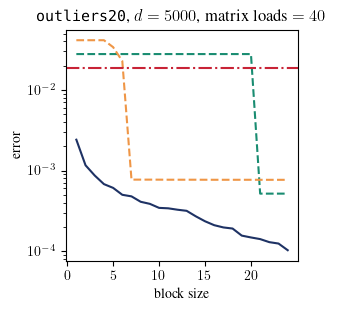

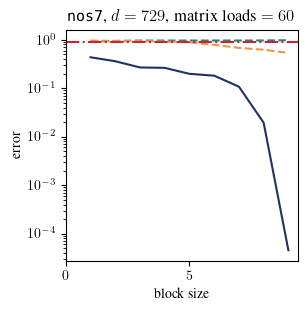

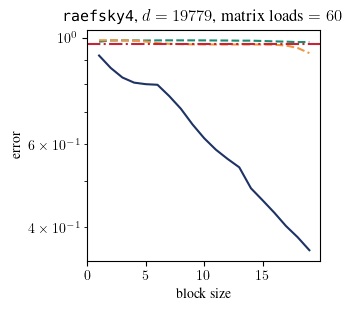

In [3]:
for experiment in experiments:

    name = experiment['name']
    Λ = experiment['Λ']
    b = experiment['b']
    ts = experiment['ts']
    reorth = experiment['reorth']
    ls = experiment['ls']
    μs = experiment['μs']

    μ = μs[0]

    d = len(Λ)
    A = sp.sparse.spdiags(Λ.reshape(1,d),[0])
    
    
    # CG
    x_CG = get_BCG_sols(A,b.reshape(d,1),ts,μs,reorth=reorth)
    x_true = (1/(Λ+μ))*b
    e = x_true-x_CG[0,0]
    err_CG = np.linalg.norm((Λ+μ)**.5*e)/np.linalg.norm((Λ+μ)**.5*x_true)


    # nystrom PCG
    ss = [1,3]

    np.random.seed(0)
    Ω_full = np.random.randn(d,max(ls))

    err_PCG = np.full((len(ls),len(ss)),np.nan)
    err_BCG = np.full(len(ls),np.nan)
    for j,l in enumerate(ls):

        Ω = Ω_full[:,:l]
        
        for si,s in enumerate(ss):
            U,D = nystrom(A,Ω,s)
            
            Aμ = A + μ*sp.sparse.eye(d)
            Pμ = deflation_precond12(U,D,D[-1],μ)
            x_PCG = get_PCG_sols(Aμ,b.reshape(d,1),Pμ,ts-s-1,reorth=reorth)
            x_true = (1/(Λ+μ))*b
            e = x_true-x_PCG[0]
            err_PCG[j,si] = np.linalg.norm((Λ+μ)**.5*e)/np.linalg.norm((Λ+μ)**.5*x_true)

        
        # block CG
        B = np.hstack([b.reshape(d,1),Ω])
            
        x_BCG = get_BCG_sols(A,B,ts,μs,reorth=reorth)
        x_true = (1/(Λ+μ))*b
        e = x_true-x_BCG[0,0]
        err_BCG[j] = np.linalg.norm((Λ+μ)**.5*e)/np.linalg.norm((Λ+μ)**.5*x_true)


    fig,ax = plt.subplots(1,1,figsize=(3,3))

    si=0; s = ss[si]
    plt.plot(ls,err_PCG[:,si],ls='--',color=c3,label=f'PCG ($s={s}$)')

    si=1; s = ss[si]
    plt.plot(ls,err_PCG[:,si],ls='--',color=c4,label=f'PCG ($s={s}$)')

    
    plt.plot(ls,err_BCG,ls='-',color=c1,label='BCG')
    plt.axhline(err_CG,ls='-.',color=c2,label='CG')
        
    plt.title(f'\\texttt{{{name}}}, $d={d}$, matrix loads $={ts[0]}$')
    plt.ylabel('error')
    plt.xlabel(f'block size')

    plt.xticks(range(0,max(ls)+1,5))
    
    # plt.xscale('log')
    plt.yscale('log')
    
    plt.savefig(f"imgs/blocksize_error_{name}.pdf",bbox_inches='tight')
    
    # plt.close()